In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
protein_name = 'Hdock_Wuhan+V16ext'
fpath = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/prediction/HDX_pred_GN_cluster2_hop1_v1.csv'
df = pd.read_csv(fpath)
print(df.shape)
print(df.columns)
print(df.head())
#print(df['Batch'].unique())

(240501, 5)
Index(['Batch', 'Y_True', 'Y_Pred', 'Chain', 'Range'], dtype='object')
  Batch    Y_True    Y_Pred  Chain    Range
0  1AKZ  0.561111  0.645261      0    90-93
1  1AKZ  0.355556  0.658576      0    96-99
2  1AKZ  0.426667  0.708797      0  101-106
3  1AKZ  0.780000  0.689861      0  102-117
4  1AKZ  0.784375  0.697503      0  102-118


hUNG apo (278, 9)
hUNG-UGI complex (276, 9)
UGI apo (228, 9)
UGI-hUNG complex (228, 9)


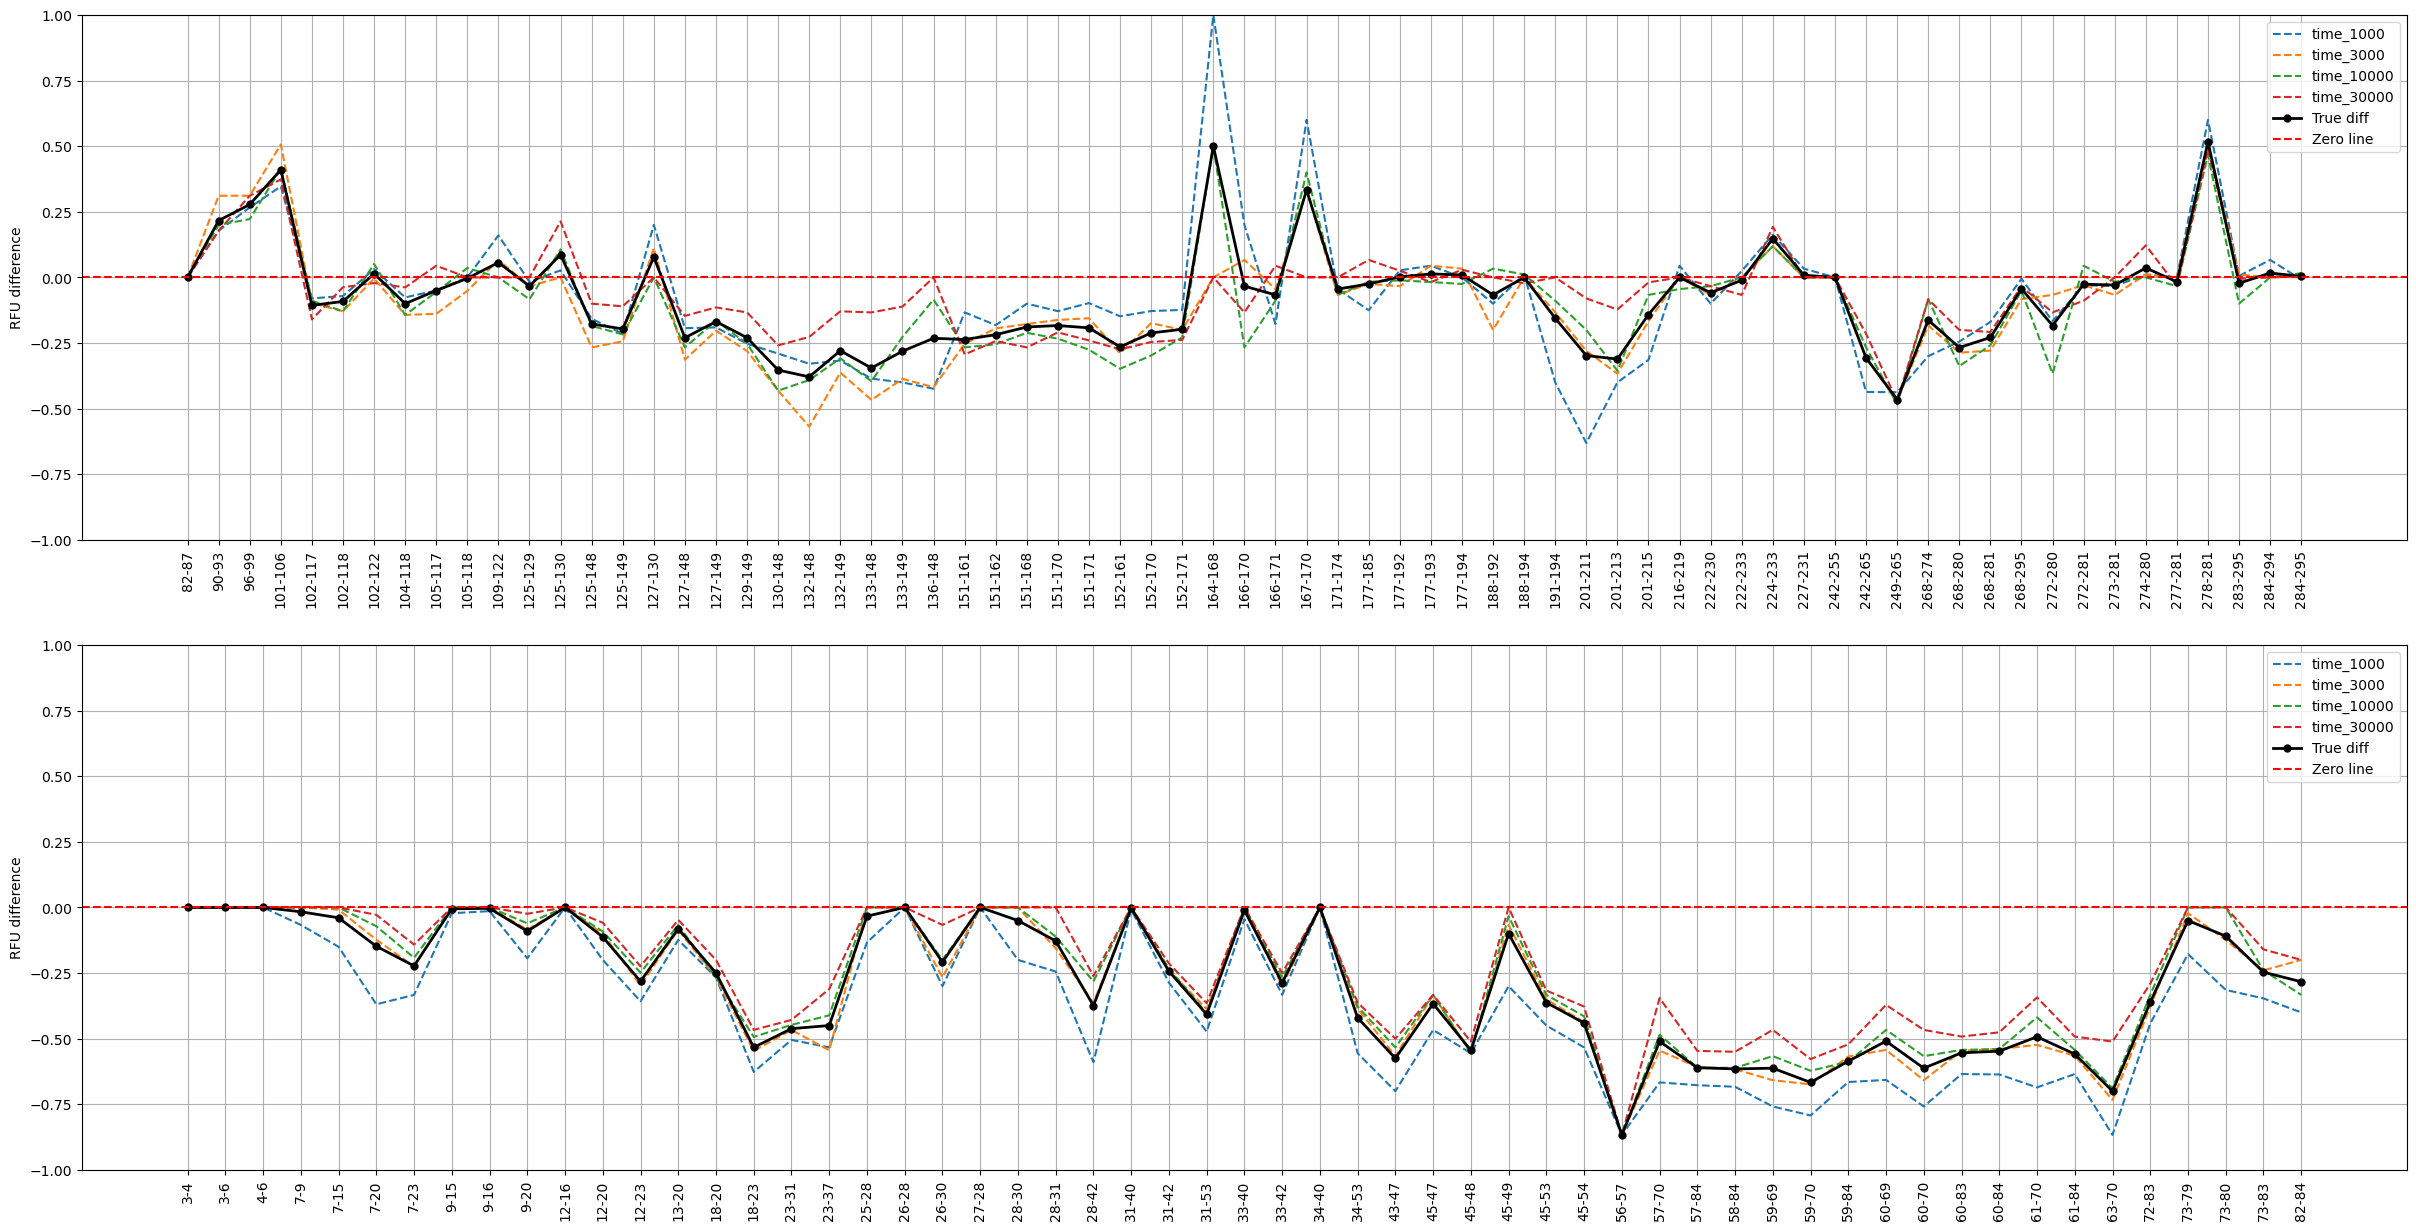

In [4]:
# get average uptake from source HDX file
# return true_diff dictionary =  [Range]: diff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_true_diff(HDX_fpath, apo_states, complex_states):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        print(protein, state, temp_HDX_df.shape)
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_uptake, complex_uptake = [], []
    apo_mtx, complex_mtx = {}, {}

    for protein, state, correction in apo_states:
        uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
        #apo_uptake.append(uptake)
        for l, u in zip(label, uptake):
            true_apo[l] = u
        apo_mtx.update(U_apo_mtx)

    for protein, state, correction in complex_states:
        uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
        #complex_uptake.append(uptake)
        for l, u in zip(label, uptake):
            true_complex[l] = u
        complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = true_complex[key] - true_apo[key]
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    return true_diff, diff_mtx

# Delta true diff 
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/HDX_files/BioChem_UNGUGI_revised.xlsx'
apo_states = [('hUNG', 'apo', -9)] # protein, state, residue id correction
complex_states = [('hUNG-UGI', 'complex', -9)]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)

plt.figure(figsize=(30, 15))
plt.tight_layout()
plt.subplot(2, 1, 1) # 2 row, 1 columns, 1st subplot
x_labels = list(true_diff.keys())
x_positions = np.arange(len(x_labels))  # numerical positions for x-axis
plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
all_times = set()
for diffs in diff_RFU_mtx.values():
    all_times.update(diffs.keys())
sorted_times = sorted(all_times, key=lambda x: float(x))
# Plotting each exposure time from diff_RFU_mtx
for time in sorted_times:
    time_values = [diff_RFU_mtx[label].get(time, 0) / 100 for label in x_labels]
    plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.ylabel('RFU difference')
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()

apo_states = [('UGI', 'apo', 0)]
complex_states = [('UGI-hUNG', 'complex', 0)]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)
plt.subplot(2, 1, 2) # 2 row, 1 columns, 1st subplot
x_labels = list(true_diff.keys())
x_positions = np.arange(len(x_labels))  # numerical positions for x-axis
plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
all_times = set()
for diffs in diff_RFU_mtx.values():
    all_times.update(diffs.keys())
sorted_times = sorted(all_times, key=lambda x: float(x))
# Plotting each exposure time from diff_RFU_mtx
for time in sorted_times:
    time_values = [diff_RFU_mtx[label].get(time, 0) / 100 for label in x_labels]
    plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.ylabel('RFU difference')
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()
plt.show()
#plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/diff_HDX.png', dpi=300)

UGI apo (228, 9)
UGI-hUNG complex (228, 9)
MAE: 0.15328575591995425


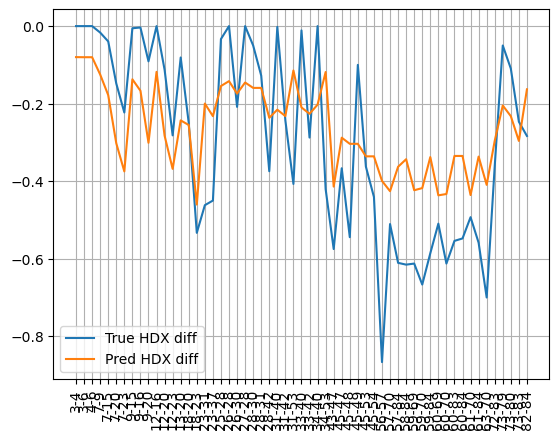

In [6]:
# show HDX difference
from sklearn.metrics import mean_absolute_error

HDX_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/HDX_files/BioChem_UNGUGI_revised.xlsx'

apo_states = [('UGI', 'apo', 0)]
complex_states = [('UGI-hUNG', 'complex', 0)]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)
complex_pred_df = df[(df['Batch'] == '1UGH')]
apo_pred_df = df[df['Batch'] == '1UGI']

'''apo_states = [('hUNG', 'apo', -9)]
complex_states = [('hUNG-UGI', 'complex', -9)]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)
complex_pred_df = df[(df['Batch'] == '1UGH')]
apo_pred_df = df[df['Batch'] == '1AKZ']'''

pred_diff = {}
for key in true_diff.keys():
    if key in complex_pred_df['Range'].values and key in apo_pred_df['Range'].values:
        complex_value = complex_pred_df[complex_pred_df['Range'] == key]['Y_Pred'].values[0]
        apo_value = apo_pred_df[apo_pred_df['Range'] == key]['Y_Pred'].values[0]
        pred_diff[key] = complex_value - apo_value

trim_true_diff = {key: true_diff[key] for key in pred_diff.keys()}

x_labels = list(pred_diff.keys())
x_index = np.arange(len(x_labels))
y_true = np.array([trim_true_diff[key] for key in x_labels])
y_pred = np.array([pred_diff[key] for key in x_labels])

MAE = mean_absolute_error(y_true, y_pred)
print('MAE:', MAE)

plt.xticks(x_index, x_labels, rotation=90)
plt.plot(x_labels, y_true, label='True HDX diff')
plt.plot(x_labels, y_pred, label='Pred HDX diff')
#plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
## extract binding site

from collections import defaultdict
import os
import numpy as np
from scipy.spatial.distance import cdist
from Bio import PDB
from itertools import groupby

class Chain:
    def __init__(self):
        self.atoms = []
        self.sequence_type = None

    def add_atom(self, atom_index, residue_index, residue_type, atom_type, coordinates):
        atom_info = {
            'atom_index': atom_index,
            'residue_index': residue_index,
            'residue_type': residue_type,
            'atom_type': atom_type,
            'coordinates': coordinates
        }
        self.atoms.append(atom_info)

    def get_atoms(self):
        return self.atoms
    
    def get_residues(self):
        # group atoms by residue
        atoms = self.get_atoms()
        key = lambda x: x['residue_index']
        #atoms = sorted(atoms, key=key)
        residues = [list(group) for key, group in groupby(atoms, key)]
        return residues

def read_PDB(key, PDB_path):
    if not os.path.isfile(PDB_path):
        print("cannot find the file", key)
        return None
    chains = defaultdict(Chain)

    with open(PDB_path, 'r') as f:
        data = f.read().strip().split('\n') 
        for line in data:
            if line[:4] == 'ATOM':
                n_res = int(line[23:26].strip())
                n_atom = int(line[6:11].strip())
                res_type = line[17:20].strip()
                atom_type = line[12:16].strip()
                chain = line[21].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                chain_id = line[21].strip()
                if atom_type == 'CA':
                    chains[chain_id].add_atom(n_atom, n_res, res_type, atom_type, [x, y, z])
    return chains

def bindingsite_extract(chains, chain1 = 'A', chain2 = 'B', dist_cutoff=3.65): ###assume only two chains in the PDB file
    chainA = chains[chain1]
    chainB = chains[chain2]
    coords_a = [atom['coordinates'] for atom in chainA.get_atoms()]
    coords_b = [atom['coordinates'] for atom in chainB.get_atoms()]

    coords_array_a = np.array(coords_a)
    coords_array_b = np.array(coords_b)
    dist_matrix = cdist(coords_array_a, coords_array_b, 'euclidean')

    pairs = dist_criterion(dist_matrix, cutoff=dist_cutoff) # different criterion can be used here
    contact_list = []
    for pair in pairs:
        resA_id = pair[0]
        resB_id = pair[1]

        resA = chainA.get_atoms()[resA_id]['residue_index']
        resB = chainB.get_atoms()[resB_id]['residue_index']
        contact_list.append((resA, resB))
    contact_list = np.array(contact_list)
    if contact_list.shape[0] == 0:
        return None, None
    
    max_res_A = max([res['residue_index'] for res in chainA.get_atoms()])
    max_res_B = max([res['residue_index'] for res in chainB.get_atoms()])
    contact_resmap = np.zeros((max_res_A, max_res_B))
    contact_resmap[contact_list[:, 0]-1, contact_list[:, 1]-1] = 1

    return contact_resmap, contact_list

def dist_criterion(dist_matrix, cutoff):
    dist_matrix = np.array(dist_matrix)
    mask = dist_matrix < cutoff
    indices = np.where(mask)
    pairs = list(zip(indices[0], indices[1]))
    return pairs

In [8]:
# calculate structure RMSD
from Bio.PDB import PDBParser
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm

def get_backbone_atoms(structure, ref_chains=['A']):
    atoms = []
    for model in structure:
        for chain in model:
            if chain.id in ref_chains:
                continue
            for residue in chain:
                # Check if the residue has the backbone atoms (N, CA, C)
                try:
                    #atoms.append(residue['N'].get_coord())
                    atoms.append(residue['CA'].get_coord())
                    #atoms.append(residue['C'].get_coord())
                except KeyError:
                    # Skip residues that don't have a complete set of backbone atoms
                    continue
    return atoms

def get_RMSD(pdb_dir, model2, ref_model, ref_chains=['A']): # ref_chains: chains to be excluded/ not compared
    parser = PDBParser()
    structure1 = parser.get_structure("Protein1", f"{pdb_dir}/{ref_model}.pdb")
    structure2 = parser.get_structure("Protein2", f"{pdb_dir}/{model2}.pdb")

    backbone_atoms1 = get_backbone_atoms(structure1, ref_chains)
    backbone_atoms2 = get_backbone_atoms(structure2, ref_chains)
    # calcualte the distance between backbone_atoms1 and backbone_atoms2
    rmsd = np.sqrt(np.sum((np.array(backbone_atoms1) - np.array(backbone_atoms2))**2)/len(backbone_atoms1))
    return rmsd

def preload_pdb_structures(pdb_dir, model_list):
    parser = PDBParser()
    structures = {}
    for model in tqdm(model_list):
        path = f"{pdb_dir}/{model}.pdb"
        try:
            structure = parser.get_structure(model, path)
            structures[model] = structure
        except Exception as e:
            print(f"Failed to parse {model}: {e}")
    return structures


UGI apo (228, 9)
UGI-hUNG complex (228, 9)
hUNG apo (278, 9)
hUNG-UGI complex (276, 9)


100%|██████████| 500/500 [00:13<00:00, 36.00it/s]
500it [01:25,  5.85it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(0.03233035507603709, 1, 2.8588881741045875), (0.034833686788796975, 4, 4.6108416693040155), (0.035252254518967435, 413, 48.88858117088733), (0.035405983049495805, 39, 9.26028713260022), (0.03552885306542451, 132, 9.430639327580367), (0.03585276301983237, 377, 40.35804408740562), (0.0358928250910298, 43, 12.77113619765146), (0.03595527971675068, 306, 14.116849580312554), (0.03603019793765133, 396, 53.77368664133044), (0.03609113381968939, 24, 12.301369628657358)]


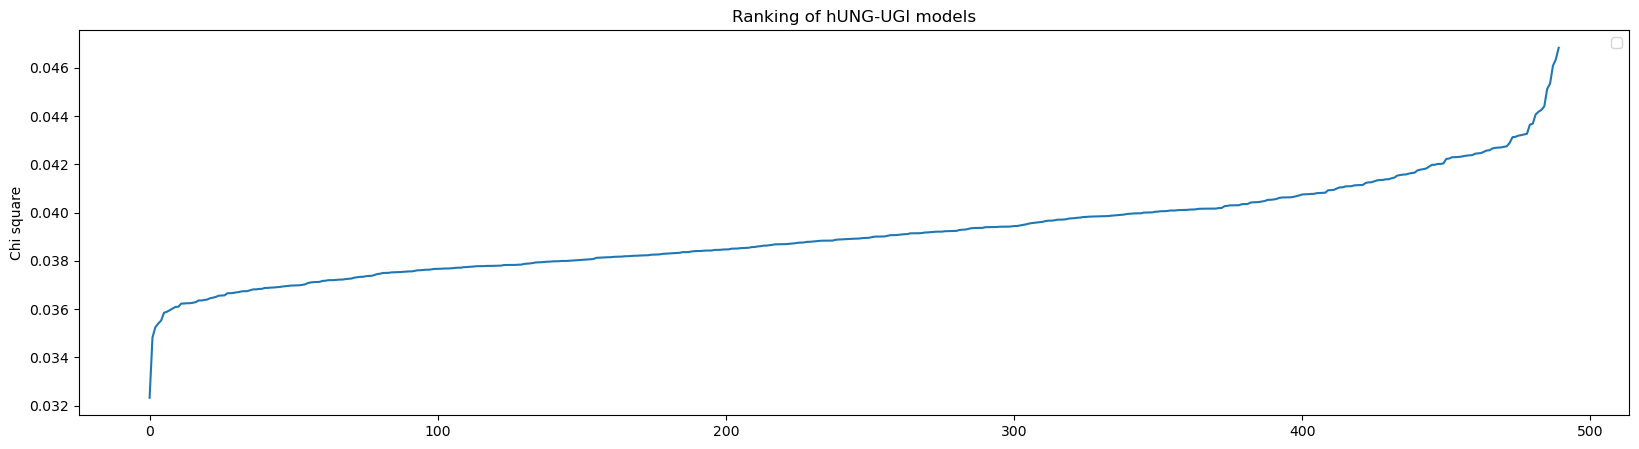

In [22]:
# batch MAE
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Clip predictions to avoid log(0)
    bce = -np.sum(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)) / y_true.shape[0]
    return bce
def mean_squared_error(y_true, y_pred, error_limit):
    return np.mean(((y_true - y_pred)/error_limit) ** 2)

def get_mae(df, complex_batchname, apo_batchname, true_diff):
    complex_pred_df = df[(df['Batch'] == complex_batchname)]
    apo_pred_df = df[df['Batch'] == apo_batchname]
    if complex_pred_df.shape[0] == 0 or apo_pred_df.shape[0] == 0:
        return None

    pred_diff = {}
    for key in true_diff.keys():
        if key in complex_pred_df['Range'].values and key in apo_pred_df['Range'].values:
            complex_value = complex_pred_df[complex_pred_df['Range'] == key]['Y_Pred'].values[0]
            apo_value = apo_pred_df[apo_pred_df['Range'] == key]['Y_Pred'].values[0]
            pred_diff[key] = complex_value - apo_value

    trim_true_diff = {key: true_diff[key] for key in pred_diff.keys()}

    x_labels = list(pred_diff.keys())
    y_true = np.array([trim_true_diff[key] for key in x_labels])
    y_pred = np.array([pred_diff[key] for key in x_labels])
    if y_true.shape[0] == 0 or y_pred.shape[0] == 0:
        return None

    error_limit = 1
    loss = mean_squared_error(y_true, y_pred, error_limit)
    return loss

HDX_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/HDX_files/BioChem_UNGUGI_revised.xlsx'
apo_states = [('UGI', 'apo', 0)]
complex_states = [('UGI-hUNG', 'complex', 0)]
true_diff_ligand, _ = get_true_diff(HDX_fpath, apo_states, complex_states)

apo_states = [('hUNG', 'apo', -9)]
complex_states = [('hUNG-UGI', 'complex', -9)]
true_diff_target, _ = get_true_diff(HDX_fpath, apo_states, complex_states)

pdb_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure/1UGH'
ref_model = '1UGH'
ref_chains = ['A']
complex_batches = [f'MODEL_{i}_REVISED' for i in range(1, 501)]
structures = preload_pdb_structures(pdb_dir, complex_batches)

apo_ref = ['1AKZ', '1UGI']
maes = []
rmsd = []
jaccard = []

## OPTION: extract binding site
chains = read_PDB('', f'{pdb_dir}/{ref_model}.pdb')
_, contact_list1 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)

for i, batch in tqdm(enumerate(complex_batches)):
    mae_ligand = get_mae(df, batch, apo_ref[1], true_diff_ligand)
    mae_target = get_mae(df, batch, apo_ref[0], true_diff_target)
    if mae_ligand is not None and mae_target is not None:
        mae = (mae_ligand + mae_target) / 2
        maes.append(mae)
        rmsd.append(get_RMSD(pdb_dir, batch, ref_model, ref_chains))

        ## OPTION: extract binding site to calculate jaccard index
        chains = read_PDB('UNG-UGI', f'{pdb_dir}/{batch}.pdb')
        _, contact_list2 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)
        j_index = len(set.intersection(set(contact_list1[:,0]), set(contact_list2[:,0]))) / len(set.union(set(contact_list1[:,0]), set(contact_list2[:,0])))
        jaccard.append(j_index)

batch_id = [int(i.split('_')[1]) for i in complex_batches]
sorted_batch = sorted(zip(maes, batch_id , rmsd), key=lambda x: x[0])
print(sorted_batch[:10])

plt.figure(figsize = (20, 5))
#plt.axvspan(-0.5, 9.5, color='green', label = 'top 10 models', alpha=0.3)
plt.plot([i[0] for i in sorted_batch])
plt.ylabel('Chi square')
plt.title(f'Ranking of hUNG-UGI models')
plt.legend()
plt.show()
#plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_ranking.png')

PearsonRResult(statistic=0.0470232517844945, pvalue=0.29888832513152097)
SignificanceResult(statistic=0.004393442806882978, pvalue=0.9227223567867354)
-11.551989125770575


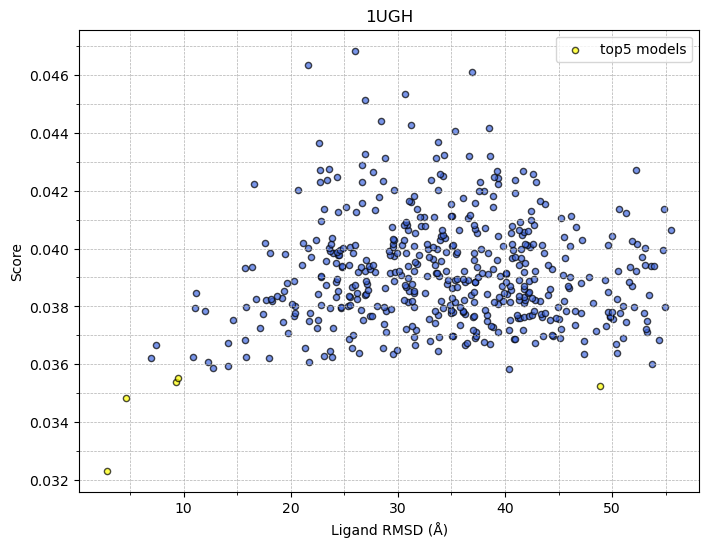

In [25]:
# plot RMSD and mae index
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from matplotlib.ticker import AutoMinorLocator

protein_name = '1UGH'
rmsd = np.array([i[2] for i in sorted_batch])
maes = np.array([i[0] for i in sorted_batch])

pcc = pearsonr(maes, rmsd)
scc = spearmanr(maes, rmsd)
r_squared = r2_score(rmsd, maes)
print(pcc)
print(scc)
print(r_squared)

plt.figure(figsize=(8, 6))
plt.ylabel('Score')
plt.xlabel('Ligand RMSD (Å)')
plt.scatter(rmsd[:5], maes[:5], alpha=0.7, edgecolor='black', color='yellow', s=20, label = 'top5 models')
plt.scatter(rmsd[5:], maes[5:], alpha=0.7, edgecolor='black', color='royalblue', s=20)

plt.title(f'1UGH')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.legend()
plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/{protein_name}_RMSD_MAE.png', dpi = 300)

In [43]:
# calculate structure RMSD
from Bio.PDB import PDBParser
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm

def get_backbone_atoms(structure, ref_chains=['A']):
    atoms = []
    for model in structure:
        for chain in model:
            if chain.id in ref_chains:
                continue
            for residue in chain:
                # Check if the residue has the backbone atoms (N, CA, C)
                try:
                    #atoms.append(residue['N'].get_coord())
                    atoms.append(residue['CA'].get_coord())
                    #atoms.append(residue['C'].get_coord())
                except KeyError:
                    # Skip residues that don't have a complete set of backbone atoms
                    continue
    return atoms

def get_RMSD(pdb_dir, model2, ref_model, ref_chains=['A']): # ref_chains: chains to be excluded/ not compared
    parser = PDBParser()
    structure1 = parser.get_structure("Protein1", f"{pdb_dir}/{ref_model}.pdb")
    structure2 = parser.get_structure("Protein2", f"{pdb_dir}/{model2}.pdb")

    backbone_atoms1 = get_backbone_atoms(structure1, ref_chains)
    backbone_atoms2 = get_backbone_atoms(structure2, ref_chains)
    # calcualte the distance between backbone_atoms1 and backbone_atoms2
    rmsd = np.sqrt(np.sum((np.array(backbone_atoms1) - np.array(backbone_atoms2))**2)/len(backbone_atoms1))
    return rmsd

def preload_pdb_structures(pdb_dir, model_list):
    parser = PDBParser()
    structures = {}
    for model in tqdm(model_list):
        path = f"{pdb_dir}/{model}.pdb"
        try:
            structure = parser.get_structure(model, path)
            structures[model] = structure
        except Exception as e:
            print(f"Failed to parse {model}: {e}")
    return structures

pdb_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure'
ref_model = '1UGH'
ref_chains = ['A']
model_list = [f'MODEL_{i}_REVISED' for i in range(1, 1956)]
'''
structures = preload_pdb_structures(pdb_dir, model_list)
ligand_positions = []
for model in model_list:
    structure = structures[model]
    ligand_positions.append(get_backbone_atoms(structure, ref_chains))

ligand_positions = np.array(ligand_positions)
'''
rmsd = []
for model2 in tqdm(model_list):
    rmsd.append(get_RMSD(pdb_dir, model2, ref_model, ref_chains))


100%|██████████| 1955/1955 [02:15<00:00, 14.41it/s]


In [53]:
rmsd = np.array(rmsd)
sorted_rmsd = np.argsort(rmsd)
print(sorted_rmsd[:10])
print(rmsd[sorted_rmsd[:10]])
print(np.where(rmsd < 3))

[  0   3  69   5 452  39 135 614  52 529]
[ 2.85888817  4.61084167  5.62877345  6.89785817  7.40274452  9.26028713
  9.43063933 10.03216827 10.84303281 10.92437093]
(array([0]),)


In [16]:
print(ligand_positions.shape)
ligand_positions = np.mean(ligand_positions, axis=1)
print(ligand_positions.shape)

(1955, 82, 3)
(1955, 3)


151


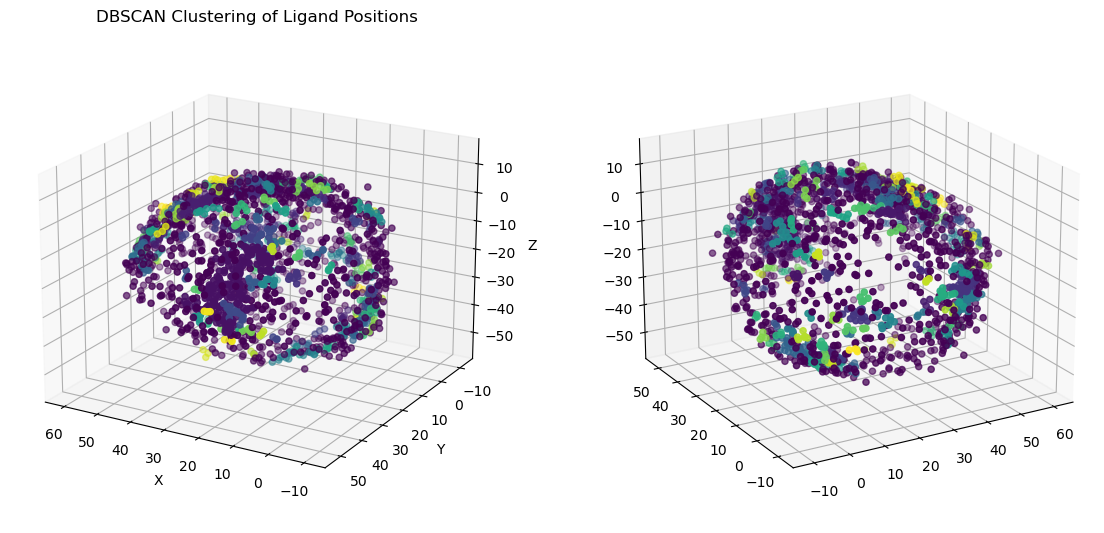

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

'''rmsd_mtx = torch.load('/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/rmsd_matrix.pt', map_location='cpu')
print(rmsd_mtx.shape)
#convert to numpy array
rmsd_mtx = rmsd_mtx.numpy()
print(np.where(rmsd_mtx[0,:] < 5))
plt.hist(rmsd_mtx[0], bins=100)
plt.show()'''

#DBSCAN
dbscan = DBSCAN(eps=2, min_samples=3)
clusters = dbscan.fit_predict(ligand_positions)
print(max(clusters))

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(ligand_positions[:, 0], ligand_positions[:, 1], ligand_positions[:, 2], c=clusters, cmap='viridis')
ax1.view_init(elev=20, azim=120)
ax1.set_title('DBSCAN Clustering of Ligand Positions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(ligand_positions[:, 0], ligand_positions[:, 1], ligand_positions[:, 2], c=clusters, cmap='viridis')
ax2.view_init(elev=20, azim=240)
plt.show()

In [29]:
print(len(maes))

print(len(rmsd))

110
110


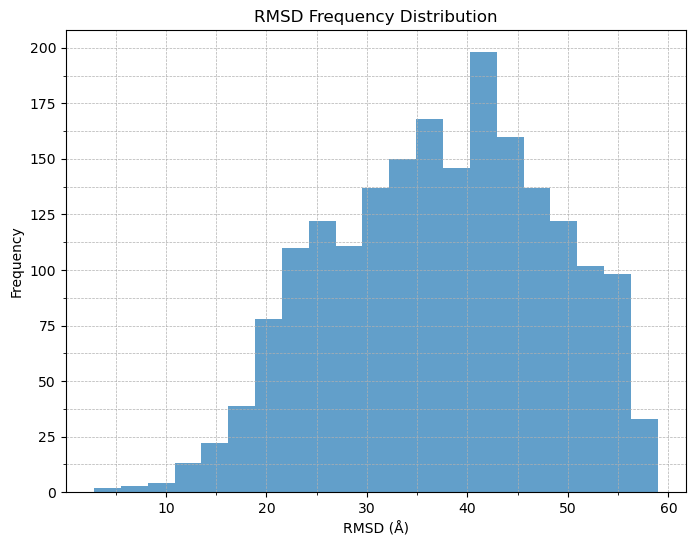

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

rmsd = np.array(rmsd)

q25, q75 = np.percentile(rmsd, [25, 75])
bin_width = 2 * (q75 - q25) * len(rmsd) ** (-1/3)
bins = int((rmsd.max() - rmsd.min()) / bin_width)

plt.figure(figsize=(8, 6))
plt.hist(rmsd, bins=bins, alpha=0.7)

# Adding a vertical line for the mean
mean_rmsd = np.mean(rmsd)
#plt.axvline(mean_rmsd, color='red', linestyle='dashed', linewidth=1)
#plt.text(mean_rmsd+0.05, 50, f'Mean: {mean_rmsd:.2f}', color = 'red')

plt.title('RMSD Frequency Distribution')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/rmsd_distribution.png', dpi=300)

(100, 6)
(100, 6)
(100, 6)
PearsonRResult(statistic=0.369570577961576, pvalue=0.00015424823371145042)
SignificanceResult(statistic=0.30851485148514846, pvalue=0.0017907178376343881)


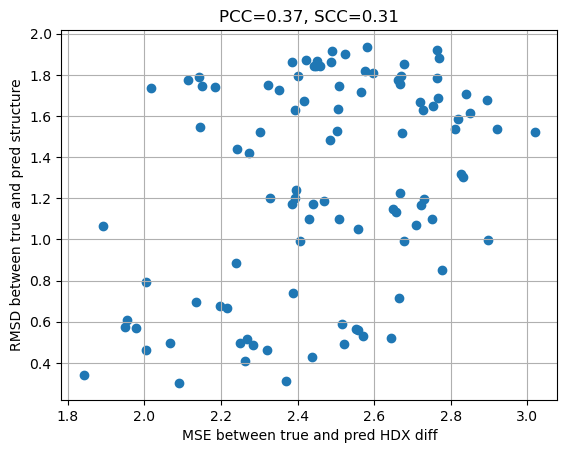

In [97]:
print(rmsd_data.shape)
print(jaccard_data.shape)

eps = 1e-6
temp_jaccard = 1-jaccard_data
#temp_jaccard = np.log(1-jaccard_data+eps)

rescaled_jaccard = (temp_jaccard - np.min(temp_jaccard)) / (np.max(temp_jaccard) - np.min(temp_jaccard))
rescaled_rmsd = (rmsd_data - np.min(rmsd_data)) / (np.max(rmsd_data) - np.min(rmsd_data))
combined_score = rescaled_jaccard + rescaled_rmsd
print(combined_score.shape)

from scipy.stats import pearsonr, spearmanr
# plot RMSD and mae index
pcc = pearsonr(maes, combined_score[:,0])
scc = spearmanr(maes, combined_score[:,0])
print(pcc)
print(scc)

plt.xlabel('MSE between true and pred HDX diff')
plt.ylabel('RMSD between true and pred structure')
plt.grid()
plt.title(f'PCC={pcc[0]:.2f}, SCC={scc[0]:.2f}')
plt.scatter(maes, combined_score[:,0])


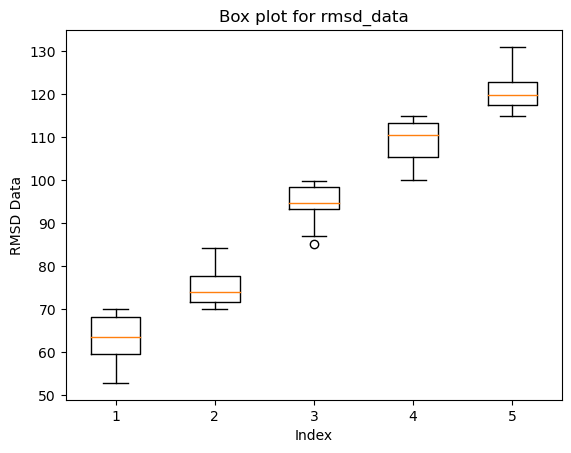

In [24]:

rmsd_bins = [0, 70, 85, 100, 115, 200]
rmsd_labels = [f'{rmsd_bins[i]}-{rmsd_bins[i+1]}' for i in range(len(rmsd_bins)-1)]
rmsd_group = np.digitize(rmsd_data, bins=rmsd_bins)

rmsd_digitize = []
for i in range(1, len(rmsd_bins)):
    rmsd_digitize.append(rmsd_data[rmsd_group == i])
rmsd_digitize = np.array(rmsd_digitize)
plt.figure()
plt.boxplot(rmsd_digitize)
plt.title('Box plot for rmsd_data')
plt.xlabel('Index')
plt.ylabel('RMSD Data')
plt.show()

In [1]:
## extract binding site

from collections import defaultdict
import os
import numpy as np
from scipy.spatial.distance import cdist
from Bio import PDB
from itertools import groupby

class Chain:
    def __init__(self):
        self.atoms = []
        self.sequence_type = None

    def add_atom(self, atom_index, residue_index, residue_type, atom_type, coordinates):
        atom_info = {
            'atom_index': atom_index,
            'residue_index': residue_index,
            'residue_type': residue_type,
            'atom_type': atom_type,
            'coordinates': coordinates
        }
        self.atoms.append(atom_info)

    def get_atoms(self):
        return self.atoms
    
    def get_residues(self):
        # group atoms by residue
        atoms = self.get_atoms()
        key = lambda x: x['residue_index']
        #atoms = sorted(atoms, key=key)
        residues = [list(group) for key, group in groupby(atoms, key)]
        return residues

def read_PDB(key, PDB_path):
    if not os.path.isfile(PDB_path):
        print("cannot find the file", key)
        return None
    chains = defaultdict(Chain)

    with open(PDB_path, 'r') as f:
        data = f.read().strip().split('\n') 
        for line in data:
            if line[:4] == 'ATOM':
                n_res = int(line[23:26].strip())
                n_atom = int(line[6:11].strip())
                res_type = line[17:20].strip()
                atom_type = line[12:16].strip()
                chain = line[21].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                chain_id = line[21].strip()
                if atom_type == 'CA':
                    chains[chain_id].add_atom(n_atom, n_res, res_type, atom_type, [x, y, z])
    return chains

def bindingsite_extract(chains, chain1 = 'A', chain2 = 'B', dist_cutoff=3.65): ###assume only two chains in the PDB file
    chainA = chains[chain1]
    chainB = chains[chain2]
    coords_a = [atom['coordinates'] for atom in chainA.get_atoms()]
    coords_b = [atom['coordinates'] for atom in chainB.get_atoms()]

    coords_array_a = np.array(coords_a)
    coords_array_b = np.array(coords_b)
    dist_matrix = cdist(coords_array_a, coords_array_b, 'euclidean')

    pairs = dist_criterion(dist_matrix, cutoff=dist_cutoff) # different criterion can be used here
    contact_list = []
    for pair in pairs:
        resA_id = pair[0]
        resB_id = pair[1]

        resA = chainA.get_atoms()[resA_id]['residue_index']
        resB = chainB.get_atoms()[resB_id]['residue_index']
        contact_list.append((resA, resB))
    contact_list = np.array(contact_list)
    if contact_list.shape[0] == 0:
        return None, None
    
    max_res_A = max([res['residue_index'] for res in chainA.get_atoms()])
    max_res_B = max([res['residue_index'] for res in chainB.get_atoms()])
    contact_resmap = np.zeros((max_res_A, max_res_B))
    contact_resmap[contact_list[:, 0]-1, contact_list[:, 1]-1] = 1

    return contact_resmap, contact_list

def dist_criterion(dist_matrix, cutoff):
    dist_matrix = np.array(dist_matrix)
    mask = dist_matrix < cutoff
    indices = np.where(mask)
    pairs = list(zip(indices[0], indices[1]))
    return pairs

In [14]:
id_list = [80, 84, 50, 69, 1, 12, 40, 96, 67, 41]
pdb_list = [f'{protein_name}_{i}_revised.pdb' for i in id_list]

rec_chain = ['A', 'C']
lig_chain = ['D', 'E']

map_dict = {}
for pdb in pdb_list:
    print(pdb)
    pdb_fpath = f'/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/hdock/{protein_name}/{pdb}'
    chains = read_PDB('model1', pdb_fpath)
    for rec in rec_chain:
        for lig in lig_chain:
            contact_, contact_list = bindingsite_extract(chains, chain1=rec, chain2=lig, dist_cutoff=10)
            if contact_list is None:
                continue
            if (rec, lig) not in map_dict.keys():
                map_dict[(rec, lig)] = []
            map_dict[(rec, lig)].extend(list(contact_list))
print(map_dict.keys())

D_contact = map_dict[('A', 'D')] + map_dict[('C', 'D')]
E_contact = map_dict[('A', 'E')] + map_dict[('C', 'E')]

D_res_map = np.zeros((999, 128))
E_res_map = np.zeros((999, 105))

for pos in D_contact:
    D_res_map[pos[0]-1, pos[1]-1] += 1
for pos in E_contact:
    E_res_map[pos[0]-1, pos[1]-1] += 1

Hdock_Wuhan+V16ext_80_revised.pdb
Hdock_Wuhan+V16ext_84_revised.pdb
Hdock_Wuhan+V16ext_50_revised.pdb
Hdock_Wuhan+V16ext_69_revised.pdb
Hdock_Wuhan+V16ext_1_revised.pdb
Hdock_Wuhan+V16ext_12_revised.pdb
Hdock_Wuhan+V16ext_40_revised.pdb
Hdock_Wuhan+V16ext_96_revised.pdb
Hdock_Wuhan+V16ext_67_revised.pdb
Hdock_Wuhan+V16ext_41_revised.pdb
dict_keys([('A', 'D'), ('A', 'E'), ('C', 'E'), ('C', 'D')])


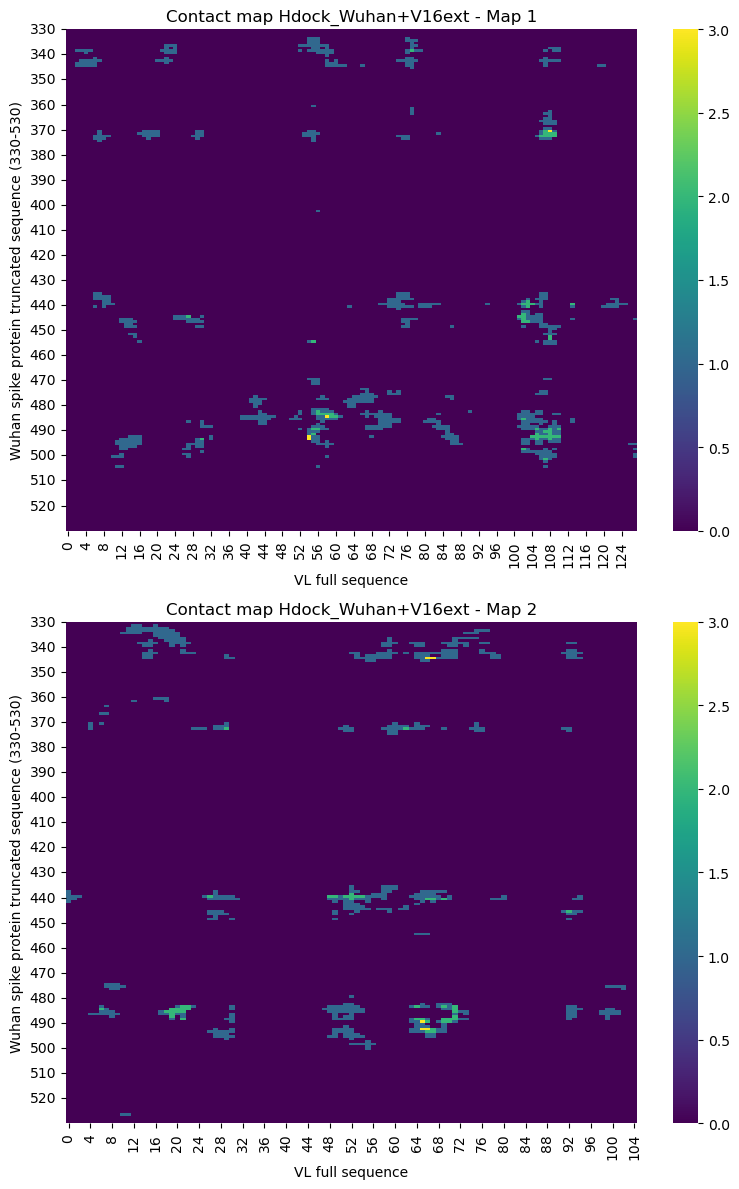

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
def plot_resmap(res_map1, res_map2):
    fig, axs = plt.subplots(2, 1, figsize=(8,12))  # create a figure with two subplots arranged vertically

    # plot the first heatmap
    sns.heatmap(res_map1, cmap='viridis', ax=axs[0])
    axs[0].set_xlabel('VL full sequence')
    axs[0].set_ylabel('Wuhan spike protein truncated sequence (330-530)')
    axs[0].set_title(f'Contact map {protein_name} - Map 1')
    axs[0].set_yticks(np.arange(0, res_map1.shape[0], 10))
    axs[0].set_yticklabels(np.arange(330, 530, 10))

    # plot the second heatmap
    sns.heatmap(res_map2, cmap='viridis', ax=axs[1])
    axs[1].set_xlabel('VL full sequence')
    axs[1].set_ylabel('Wuhan spike protein truncated sequence (330-530)')
    axs[1].set_title(f'Contact map {protein_name} - Map 2')
    axs[1].set_yticks(np.arange(0, res_map2.shape[0], 10))
    axs[1].set_yticklabels(np.arange(330, 530, 10))

    plt.tight_layout()  # adjust the layout so that the plots do not overlap
    plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_resmap.png')

plot_resmap(D_res_map[330:530, :], E_res_map[330:530, :])

In [4]:
from pepGraph_utlis import read_PDB, bindingsite_extract

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/RTT_BCD/hdock/Hdock_AF_rtt+bcd_G1/Hdock_AF_rtt+bcd_G1_20_revised.pdb'
chains = read_PDB('Hdock_AF_rtt+bcd_G1_1_revised', pdb_fpath)
contact_resmap, contact_list1 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)


pdb_fpath = '/home/lwang/models/HDX_LSTM/data/RTT_BCD/hdock/Hdock_AF_rtt+bcd_G1/AF_rtt_bcd_complex.pdb'
chains = read_PDB('AF_rtt_bcd_complex', pdb_fpath)
contact_resmap, contact_list2 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)

#compute jaccard index
def jaccard_index(contact_list1, contact_list2):
    set1 = set([tuple(item) for item in contact_list1])
    set2 = set([tuple(item) for item in contact_list2])
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard = len(intersection) / len(union)
    return jaccard
print(contact_list1.shape)
print(contact_list2.shape)
print(contact_list1)
print(set(contact_list2[:, 0]))

j_index = len(set.intersection(set(contact_list1[:, 0]), set(contact_list2[:, 0])))/ len(set.union(set(contact_list1[:, 0]), set(contact_list2[:, 0])))
print(j_index)

#j_index= jaccard_index(np.unique(contact_list1[:, 0]), np.unique(contact_list2[:, 0]))
print(j_index)

(36, 2)
(60, 2)
[[ 70 124]
 [ 70 125]
 [ 70 126]
 [ 70 127]
 [ 70 251]
 [ 71 127]
 [ 71 249]
 [ 71 251]
 [ 73 127]
 [ 73 128]
 [ 73 129]
 [ 95 249]
 [100 248]
 [100 249]
 [173 128]
 [174 128]
 [174 129]
 [174 130]
 [175 130]
 [176 152]
 [178 154]
 [187 131]
 [188 130]
 [188 131]
 [188 132]
 [191 131]
 [191 132]
 [191 274]
 [191 275]
 [192 132]
 [192 275]
 [194 275]
 [195 132]
 [195 248]
 [195 274]
 [195 275]]
{192, 195, 70, 71, 72, 73, 74, 75, 170, 171, 172, 173, 174, 175, 94, 95}
0.391304347826087
0.391304347826087


In [1]:
from pyhdx import read_dynamx, HDXMeasurement
from pyhdx.process import filter_peptides, apply_control, correct_d_uptake
from pyhdx.plot import peptide_coverage
import proplot as pplt
from pathlib import Path
import pandas as pd
import numpy as np

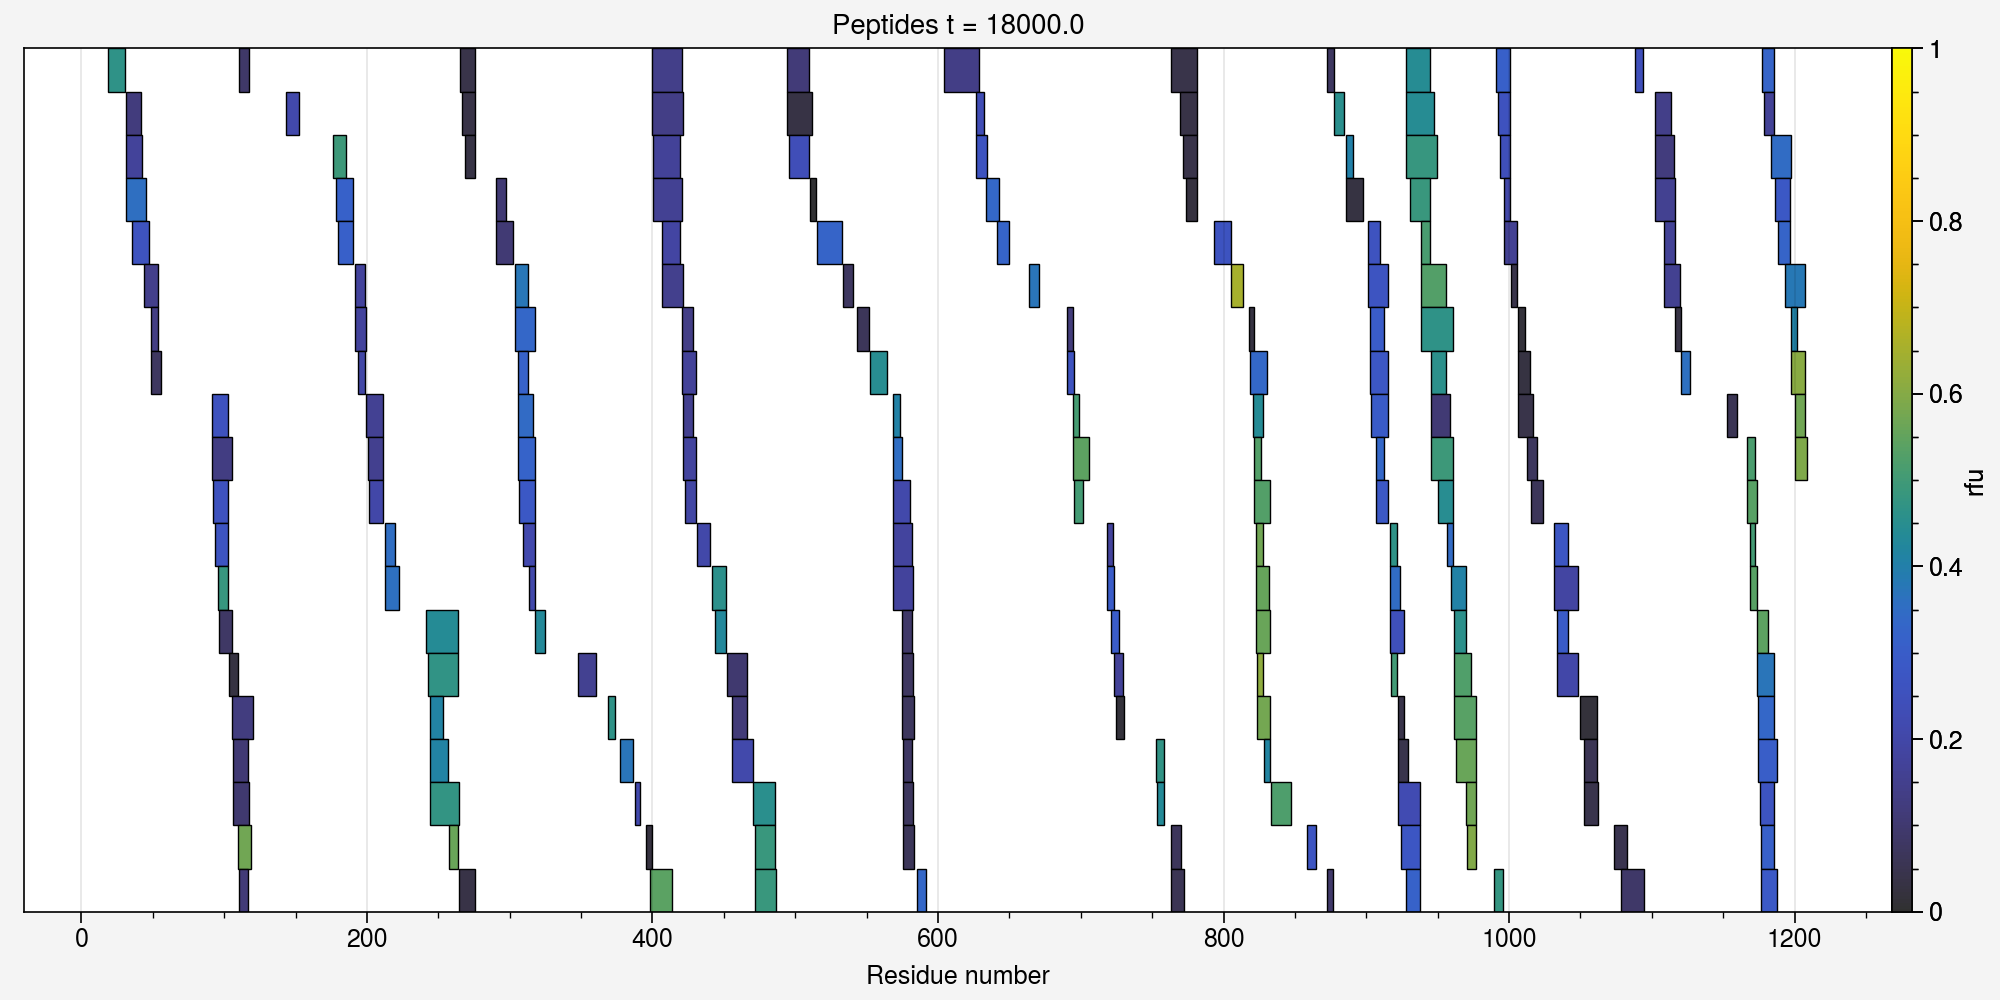

In [4]:
fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.csv'
data = read_dynamx(fpath)
data['rfu'] = data['%d'] / 100

peptides = data[(data['protein'] == 'WUHAN_2nd') & (data['state'] == 'apo')]

peptides_corrected = correct_d_uptake(peptides, drop_first=1, d_percentage=90.0)

sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
temperature, pH = 273.15 + 25, 7.5

hdxm = HDXMeasurement(
    peptides_corrected, sequence = sequence, pH=pH, temperature=temperature, name="My HDX measurement"
)

fig, ax = pplt.subplots(figsize=(10, 5))
i = 0
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
t = ax.set_title(f"Peptides t = {hdxm.timepoints[i]}")
l = ax.set_xlabel("Residue number")

In [5]:
import numpy as np
import pandas as pd
import proplot as pplt
from scipy.optimize import lsq_linear
from pathlib import Path
import yaml

from pyhdx.models import Coverage
from pyhdx.plot import peptide_coverage
from pyhdx.batch_processing import StateParser
from pyhdx.fitting import fit_d_uptake
from pyhdx.config import cfg

/home/lwang/models/mambaforge/envs/pyhdx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def compute_d_uptake(fpath, states, sequence):
    data = read_dynamx(fpath)
    data['rfu'] = data['%d'] / 100

    fit_result = []
    for state in states:
        peptides = data[(data['protein'] == state[0]) & (data['state'] == state[1])]
        peptides_corrected = correct_d_uptake(peptides, drop_first=1, d_percentage=90.0)
        temperature, pH = 273.15 + 25, 7.5
        hdxm = HDXMeasurement(
            peptides_corrected, sequence = sequence, pH=pH, temperature=temperature, name="My HDX measurement"
        )
        hdx_t = hdxm[1]
        fit_result.append(fit_d_uptake(hdx_t, r1=1.0, repeats=20))
    
    fit_diff = fit_result[1].d_uptake.mean(axis=0) - fit_result[0].d_uptake.mean(axis=0)

    return hdx_t.r_number ,fit_diff

sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.csv'
states = [('WUHAN_2nd', 'apo', 'A'), ('WUHAN_2nd', 'VH16_VL104', 'A')]
r_id, fit_diff = compute_d_uptake(fpath, states, sequence)


100%|██████████| 20/20 [04:00<00:00, 12.03s/it]


In [6]:
hdx_t = hdxm[1]
b = hdx_t.data["uptake_corrected"].values
X_inv = np.linalg.pinv(hdx_t.X)
d_inv = X_inv.dot(b)
# Remove parts which do not exchange (prolines, coverage gaps)
d_inv[~hdx_t["exchanges"]] = np.nan

res = lsq_linear(hdx_t.X, b, method="bvls", bounds=(0, 1))
d_lsq = res.x
d_lsq[~hdx_t["exchanges"]] = np.nan

fit_result_1 = fit_d_uptake(hdx_t, r1=1.0, repeats=20)

100%|██████████| 20/20 [04:03<00:00, 12.18s/it]


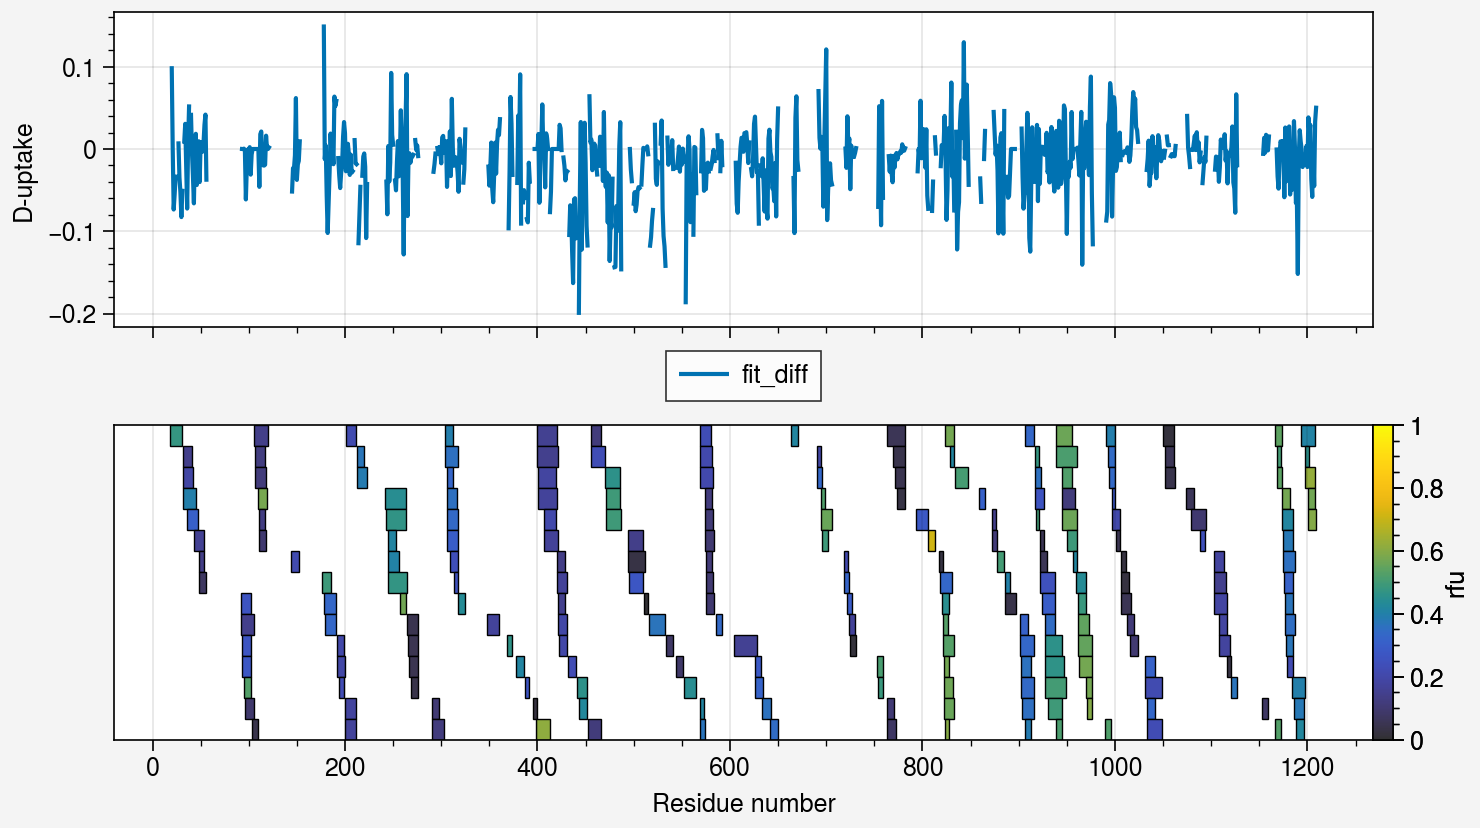

In [33]:
d_rfu = hdx_t.rfu_residues * 90.0 * 0.01

def prepare_kwargs(fit_result):
    """Prepare plot kwargs for fit result"""
    d = {
        "y": fit_result.d_uptake.mean(axis=0),
        "fadedata": np.percentile(fit_result.d_uptake, (5, 95), axis=0),
        "shadedata": np.percentile(fit_result.d_uptake, (25, 75), axis=0),
    }
    return d

fig, axes = pplt.subplots(nrows=2, refaspect=4, axwidth="160mm", sharey=False)
#axes[0].plot(hdx_t.r_number, d_inv, label="Matrix pinv", color="gray8")
#axes[0].plot(hdx_t.r_number, d_lsq, label="LSQ", color="gray5")

#axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_1), label="fit_r1_1")
#axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_02), label="fit_r1_02")
axes[0].line(hdx_t.r_number, fit_diff, label="fit_diff")

#axes[0].plot(hdx_t.r_number, d_rfu, label="RFU wt averaging")
axes[0].format(ylabel="D-uptake")
axes.format(xlabel="Residue number")
axes[0].legend(loc="b", ncols=5)
peptide_coverage(axes[1], hdx_t.data)
pplt.show()

In [31]:
# replace the b-factor by residue wise D-uptake
from Bio.PDB import PDBParser, PDBIO

# Define the path to your PDB file
pdb_file = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure/Wuhan_spike_bfac_to_Duptake.pdb'

# Create a PDB parser
parser = PDBParser()

# Parse the structure from file
structure = parser.get_structure('PDB', pdb_file)

# Define the chain you want to modify and the new B-factors
chain_id = 'B'  # Specify the chain ID
new_b_factors = d_uptake_dict # Dictionary of residue index to new B-factor values

# Update the B-factors for the specified chain
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                for atom in residue:
                    atom.bfactor = 0.0
                if residue.id[1] in new_b_factors:  # residue.id[1] gives the residue index
                    for atom in residue:
                        atom.bfactor = new_b_factors[residue.id[1]]

# Save the modified structure to a new PDB file
io = PDBIO()
io.set_structure(structure)
io.save('/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure/Wuhan_spike_bfac_to_Duptake.pdb')

In [6]:
import pandas as pd
import numpy as np

fpath = f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/HDX_pred_Omicron+V16noext_finetune.csv'
df = pd.read_csv(fpath)

batch_df = df[df['Batch'] == 'Hdock_Omicron+V16noext_1_revised']
print(batch_df.shape)

avg_uptake = {}
for chain in batch_df['Chain'].unique():
    chain_df = batch_df[batch_df['Chain'] == chain]
    for i, row in chain_df.iterrows():
        range_label = row['Range'].split('_')[1]
        if range_label not in avg_uptake.keys():
            avg_uptake[range_label] = []
        avg_uptake[range_label].append(float(row['Y_Pred']))
for key in avg_uptake.keys():
    avg_uptake[key] = np.mean(avg_uptake[key])
print(len(avg_uptake.keys()))

(347, 5)
117


In [46]:
# load protein as networkx graph and convert to torchdrug graph
import networkx as nx
import numpy as np
import torch
from torchdrug import data
from torch_cluster import knn_graph, radius_graph
from Bio.PDB import PDBParser, Selection

def rescale(data):
    data_max = np.max(data, axis=0)
    data_min = np.min(data, axis=0)
    
    # Avoid division by zero for constant columns by setting 0/0 to 0 directly
    range = np.where(data_max - data_min == 0, 1, data_max - data_min)
    
    rescaled_data = (data - data_min) / range
    rescaled_data = np.nan_to_num(rescaled_data, nan=0.0)
    
    return rescaled_data

def attach_node_attributes(G, embedding_file):
    embedding_data = torch.load(embedding_file)
    protein_embedding = rescale(embedding_data['embedding'].detach().numpy())
    for node in G.nodes():
        G.nodes[node]['x'] = torch.tensor(protein_embedding[node, :], dtype=torch.float32)
    return G

def ResGraph(pdb_file, embedding_file, protein_chain = ['A']): # create networkx and torchdrug graphs
    parser = PDBParser()
    structure = parser.get_structure('PDB_structure', pdb_file)
    # Filtering by protein_chain (assuming protein_chain can be a string or a list)
    if isinstance(protein_chain, str):
        chains = [chain for chain in structure.get_chains() if chain.id == protein_chain]
    else:
        chains = [chain for chain in structure.get_chains() if chain.id in protein_chain]
    residues = Selection.unfold_entities(chains, 'R')

    G = nx.MultiGraph()
    for i, residue in enumerate(residues):
        nodes_with_attributes = [
            (i, {"res_name": residue.get_resname(), "residue_coord":residue['CA'].coord, 
                 "residue_id": residue.id[1], 'chain_id': protein_chain.index(residue.get_parent().id)})
        ]
        G.add_nodes_from(nodes_with_attributes)
        #res(i, residue.get_resname(), protein_chain.index(residue.get_parent().id), residue['CA'].coord)
    
    G = attach_node_attributes(G, embedding_file)
    return G

def add_edges(G, max_distance=10, min_distance=5):
    node_coord = [G.nodes[i]['residue_coord'] for i in G.nodes]
    node_coord = torch.tensor(node_coord, dtype = torch.float32)
    batch = torch.tensor([0] * len(G.nodes))

    # add radius edges
    edge_index = radius_graph(node_coord, r=max_distance, batch=batch, loop=False)
    edge_list = edge_index.t().tolist()
    for u, v in edge_list:
        G.add_edge(u, v, edge_type='radius_edge')
    print('add radius edges:', G.number_of_edges())

    # add knn edges
    edge_index = knn_graph(node_coord, k=10, batch=batch, loop=False)
    edge_list = edge_index.t().tolist()
    for u, v in edge_list:
        G.add_edge(u, v, edge_type='knn_edge')
    print('add knn edges:', G.number_of_edges())

    # remove edges with distance smaller than min_distance
    edges_to_remove = []
    for u, v in G.edges():
        u_coord = torch.tensor(G.nodes[u]['residue_coord'], dtype = torch.float32)
        v_coord = torch.tensor(G.nodes[v]['residue_coord'], dtype = torch.float32)
        distance = torch.norm(u_coord - v_coord, dim=0)
        if distance < min_distance:
            if (u,v) not in edges_to_remove:
                edges_to_remove.append((u, v))
    G.remove_edges_from(edges_to_remove)
    print('after removing edges:', G.number_of_edges())

    # add sequential edges
    i2res_id = {(data['chain_id'], data['residue_id']): node for node, data in G.nodes(data=True)}
    for node in G.nodes:
        res_id = G.nodes[node]['residue_id']
        chain = G.nodes[node]['chain_id']
        if (chain,res_id+1) in i2res_id.keys():
            G.add_edge(node, node+1, edge_type='forward_1_edge')
        if (chain,res_id+2) in i2res_id.keys():
            G.add_edge(node, node+2, edge_type='forward_2_edge')
        if (chain,res_id-1) in i2res_id.keys():
            G.add_edge(node, node-1, edge_type='backward_1_edge')
        if (chain,res_id-2) in i2res_id.keys():
            G.add_edge(node, node-2, edge_type='backward_2_edge')
        G.add_edge(node, node, edge_type='self_edge')
    print('add sequential edges:', G.number_of_edges())
    return G

def networkx_to_tgG(G): # convert to torchdrug protein graph
    node_position = torch.as_tensor([G.nodes[node]['residue_coord'] for node in G.nodes()], dtype=torch.float32)
    num_atom = G.number_of_nodes()
    atom_type = ['CA'] * num_atom # CA - 1
    atom_type = torch.as_tensor([data.Protein.atom_name2id.get(atom, -1) for atom in atom_type])

    residue_type = []
    residue_feature = []
    residue_id = []
    id_map = {}
    for i, (node, attrs) in enumerate(G.nodes(data=True)):
        if node not in id_map.keys():
            id_map[node] = i
        residue_type.append(data.Protein.residue2id.get(attrs['res_name'], 0))
        residue_feature.append(attrs['x'])
        residue_id.append(attrs['residue_id'])
    residue_type = torch.tensor(residue_type, dtype=torch.long)
    residue_feature = torch.stack(residue_feature)
    atom2residue = torch.as_tensor([id_map[node] for node in G.nodes()], dtype=torch.long)

    edge_list = []
    bond_type = []
    edge_type_list = ['radius_edge', 'knn_edge', 'forward_1_edge', 'forward_2_edge', 'backward_1_edge', 'backward_2_edge', 'self_edge']
    for u, v, attrs in G.edges(data=True):
        edge_type = attrs['edge_type']
        u = id_map[u]
        v = id_map[v]
        if edge_type in edge_type_list:
            edge_list.append([u, v, edge_type_list.index(edge_type)])
            bond_type.append(edge_type_list.index(edge_type))

    edge_list = torch.tensor(edge_list, dtype=torch.long)
    bond_type = torch.tensor(bond_type, dtype=torch.long).unsqueeze(-1)

    protein = data.Protein(edge_list, atom_type, bond_type, view='residue', residue_number=residue_id,
                           node_position=node_position, atom2residue=atom2residue,residue_feature=residue_feature, 
                           residue_type=residue_type, num_relation = len(edge_type_list))
    '''
    with protein.graph():
        protein.y = torch.tensor(G.graph['y'], dtype=torch.float32)
        protein.range = torch.tensor(G.graph['range'], dtype=torch.float32)
        protein.chain = torch.tensor(G.graph['chain'], dtype=torch.int64)
        protein.seq_embedding = torch.tensor(G.graph['seq_embedding'], dtype=torch.float32)
    '''
    
    return protein

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/structure/AF-P03958-F1-model_v4.pdb'
embedding_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/embedding_files/AF-P03958-F1-model_v4.pt'
protein_chains = ['A']

G = ResGraph(pdb_fpath, embedding_fpath)
G = add_edges(G)
print(G)

node_list = range(5, 45)
print(node_list)
G = G.subgraph(node_list)
print(G)
protein = networkx_to_tgG(G)
print(protein)

add radius edges: 6762
add knn edges: 10282
after removing edges: 9845
add sequential edges: 11599
MultiGraph with 352 nodes and 11599 edges
range(5, 45)
MultiGraph with 40 nodes and 763 edges
atom_type: torch.Size([40])
{5: 0, 6: 1, 7: 2, 8: 3, 9: 4, 10: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 16: 11, 17: 12, 18: 13, 19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39}
tensor(39)
Protein(num_atom=40, num_bond=763, num_residue=40)


In [1]:
from torchdrug import data, utils, tasks, core, layers
from torchdrug.layers import geometry
from GearNet import GearNet
from itertools import islice
import torch

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/structure/AF-O60664-F1-model_v4.pdb'
protein = data.Protein.from_pdb(pdb_fpath)
protein.view = 'residue'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()], 
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)])

_protein = data.Protein.pack([protein]*4)
protein_ = graph_construction_model(_protein)
print("Graph before: ", _protein)
print("Graph after: ", protein_)

model = GearNet(input_dim = 67, hidden_dims = [512],
                    num_relation=7, batch_norm=True, concat_hidden=True, readout='sum', short_cut=True).to(device)


train_loader = data.DataLoader(protein_, batch_size=4)
for i, batch in enumerate(islice(train_loader, len(train_loader))):
    batch = batch.to(device)
    print(batch)
    output = model(batch, batch.node_feature.float())
    print(output.shape)


ModuleNotFoundError: No module named 'GearNet'

In [1]:
import torch
from torchdrug.layers import geometry

edge_list = torch.randint(0, 4, (2,2))
print(edge_list)

node_in, node_out = edge_list.t()[:2]
edge_index = torch.arange(edge_list.shape[0])
print(edge_index)

edge_in = edge_index[node_out.argsort()]
edge_out = edge_index[node_in.argsort()]
print(edge_in, edge_out)


tensor([[3, 2],
        [0, 2]])
tensor([0, 1])
tensor([0, 1]) tensor([1, 0])


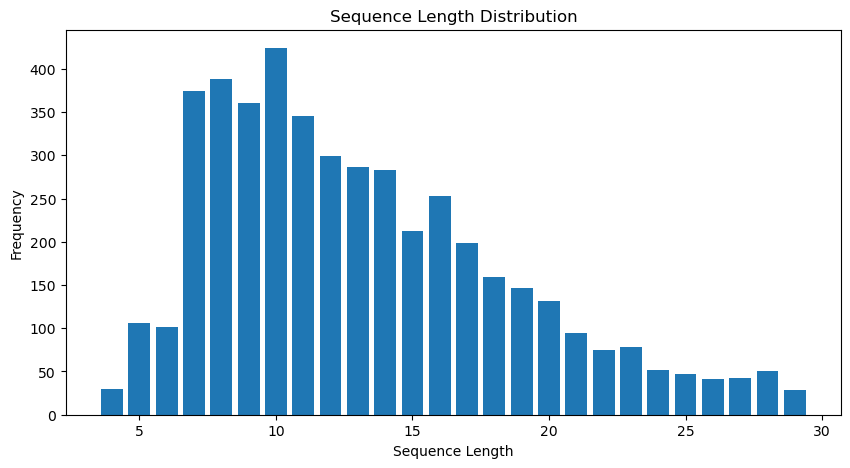

In [9]:
import torch
import os
import matplotlib.pyplot as plt

fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/graph_ensemble_LSTMGNN'

graphs = []
for file in os.listdir(fpath):
    if file.endswith('.pt'):
        graph_ensemble = torch.load(os.path.join(fpath, file))
        graphs.extend(graph_ensemble)

seqLen_dist = {}
for graph in graphs:
    seq_len = int(graph.range[1]-graph.range[0]+1)
    if seq_len not in seqLen_dist.keys():
        seqLen_dist[seq_len] = 0
    seqLen_dist[seq_len] += 1


seqLen_dist = dict(sorted(seqLen_dist.items(), key=lambda item: item[0]))
plt.figure(figsize=(10, 5))
plt.bar(seqLen_dist.keys(), seqLen_dist.values())
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()